In [36]:
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from skimage import data, util
from skimage.measure import label, regionprops

This is if running ipynb in Colab

In [37]:
# from google.colab import drive
# drive.mount('/content/drive/')

# os.chdir("/content/drive/MyDrive/ECE5242/")

If there exists files that already have the trained parameters you can load it by running this cell to get mean and covariance. Otherwise there will be a cell below that gives you the option to save the current parameters for future use.

In [54]:
def load_parameters():
    # Loading parameters
    orange_cone_rgb_mean = np.load('Data/Saved_Parameters/orange_cone_mean.npy')
    orange_cone_rgb_covariance = np.load('Data/Saved_Parameters/orange_cone_cov.npy')
    extra_cone_rgb_mean = np.load('Data/Saved_Parameters/extra_cone_rgb_mean.npy')
    extra_cone_rgb_covariance = np.load('Data/Saved_Parameters/extra_cone_rgb_covariance.npy')

#load_parameters()

Gather orange cone masks from each labeled file and append them to one big matrix. However having a big matrix will cause problems later on when creating the Covariant Matrix which is one of the parameters used within the Multivariate Gaussian distribution model. Plot this matrix on a scatter plot

Image Name:  train_1_dist30.png


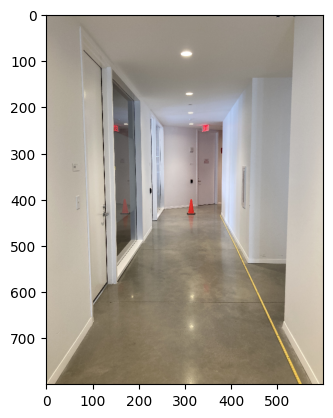

In [38]:
# This is for getting labeled image's pixels
def get_labeled_images_pixels(labeled_folder):  
    roi_pixels = np.loadtxt(os.path.join(labeled_folder, os.listdir(labeled_folder)[0]))
    for index in range(1, len(os.listdir(labeled_folder))):
    #for index in range(1, 2):
        pixels_to_concat = np.loadtxt(os.path.join(labeled_folder, os.listdir(labeled_folder)[index]))
        roi_pixels = np.concatenate((roi_pixels, pixels_to_concat))
    return roi_pixels

# This is for getting original image and number of its pixels
def get_original_image(unlabled_folder):
    for index in range(2, 3):
        unlabeled_img = mpimg.imread(os.path.join(unlabled_folder, os.listdir(unlabled_folder)[index]))
    print("Image Name: ", os.listdir(unlabled_folder)[index])

    return unlabeled_img, os.listdir(unlabled_folder)[index]

# This is for getting testing image
def get_test_image(test_folder, test_image):
    unlabeled_img = mpimg.imread(os.path.join(test_folder, test_image))
    
    return unlabeled_img


cone_labeled_folder = 'Data/Cone_Labeled'
extra_labeled_folder = 'Data/Extra_Labeled'
unlabeled_folder = 'Data/ECE5242Proj1-train'
test_folder = 'Data/Test_Images'
cone_roi_pixels = get_labeled_images_pixels(cone_labeled_folder)
extra_roi_pixels = get_labeled_images_pixels(extra_labeled_folder)
unlabeled_img, image_name = get_original_image(unlabeled_folder)
#unlabeled_img = get_test_image(test_folder, 'traffic-cones02.png')  # THIS IS WHERE YOU 

plt.imshow(unlabeled_img)

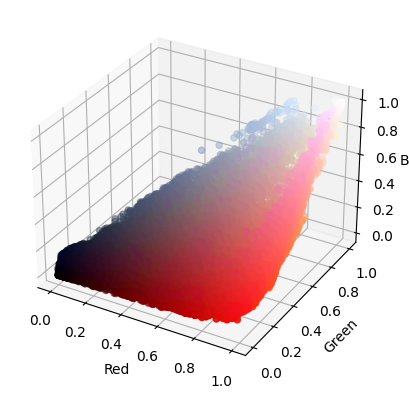

In [39]:
# Plot region of interest points onto scatter plot
def plot_region_of_interest(roi_pixels):
  fig = plt.figure()
  scatter_plot = fig.add_subplot(projection='3d')
  red_axis = roi_pixels[:, 0]
  green_axis = roi_pixels[:, 1]
  blue_axis = roi_pixels[:, 2]
  scatter_plot.scatter(red_axis, green_axis, blue_axis, c=roi_pixels)
  scatter_plot.set_xlabel('Red')
  scatter_plot.set_ylabel('Green')
  scatter_plot.set_zlabel('Blue')
  plt.show()
  plt.close()

plot_region_of_interest(cone_roi_pixels)

Once you have that you want to calculate the average orange color value(aka mean), covariance(Use this instead of variance since working with multi-dimensions), and standard deviation of this region of interest. This information can be modeled as a bell curve or otherwise known as a Multivariate Gaussian Distribution(Multivariate because dealing with RGB).

The mean tells us where the center of the distribution is and the variance tells us the spread of the data in the distribution.

In [40]:
# RGB Mean
def get_RGB_Mean(roi_pixels):
  rgb_mean = np.atleast_2d(np.mean(roi_pixels, axis=0)).T # Fast numpy method
  return rgb_mean
  # rgb_mean = np.zeros(3)
  # for i in range(len(roi_pixels)):
  #     rgb_mean[0] += roi_pixels[i][0]
  #     rgb_mean[1] += roi_pixels[i][1]
  #     rgb_mean[2] += roi_pixels[i][2]
  # rgb_mean /= len(roi_pixels)
  # rgb_mean = np.atleast_2d(rgb_mean).T
  # return rgb_mean


# RGB Covariance 
def get_RGB_Covariance(roi_pixels):
  rgb_covariance = np.cov(roi_pixels.T) # Fast numpy method
  return rgb_covariance


#orange_cone_rgb_mean = get_RGB_Mean(cone_roi_pixels)
#orange_cone_rgb_covariance = get_RGB_Covariance(cone_roi_pixels)
#extra_cone_rgb_mean = get_RGB_Mean(extra_roi_pixels)
#extra_cone_rgb_covariance = get_RGB_Covariance(extra_roi_pixels)

# EVERYTHING BELOW IS MANUAL CALCULATIONS
# orange_cone_rgb_covariance = np.zeros(3)
# for i in range(len(cone_roi_pixels)):
#     orange_cone_rgb_covariance[0] += (cone_roi_pixels[i][0] - orange_cone_rgb_mean[0]) * np.transpose((cone_roi_pixels[i][0] - orange_cone_rgb_mean[0]))
#     orange_cone_rgb_covariance[1] += (cone_roi_pixels[i][1] - orange_cone_rgb_mean[1]) * np.transpose((cone_roi_pixels[i][1] - orange_cone_rgb_mean[1]))
#     orange_cone_rgb_covariance[2] += (cone_roi_pixels[i][2] - orange_cone_rgb_mean[2]) * np.transpose((cone_roi_pixels[i][2] - orange_cone_rgb_mean[2]))
# orange_cone_rgb_covariance /= len(cone_roi_pixels)
#print(orange_cone_rgb_covariance)

# RGB STD
# orange_cone_rgb_std = cone_roi_pixels.std(0) Fast numpy method
# orange_cone_rgb_std = np.zeros(3)
# orange_cone_rgb_std[0] =  np.sqrt(orange_cone_rgb_covariance[0])
# orange_cone_rgb_std[1] =  np.sqrt(orange_cone_rgb_covariance[1])
# orange_cone_rgb_std[2] =  np.sqrt(orange_cone_rgb_covariance[2])
# print(orange_cone_rgb_std)

Need to calculate the Multivariate(multidimensional) Gaussian using the parameters calculated above to get the probability that a pixel x is the orange cone. In general each Gaussian distribution represents a color class and in our case we are calculating the Orange color class. For each pixel in the training pictures, we compare it to the gaussian model. Using this model, we check the "likelihood value" or probability of that pixel belonging to that color. Pixels with high likelihood will be labeled orange and grouped together.

SIDE NOTE: Also sigma represents covariance for multivariate.

In [55]:
def Multivariate_Gaussian(mean, covariance, img_pixel):
  transposed_pixel = np.atleast_2d(img_pixel).T

  first_half = (1 / np.sqrt((2 * math.pi) * np.linalg.det(covariance)))

  first_mat_mul = np.matmul(np.transpose(transposed_pixel - mean), np.linalg.inv(covariance))
  second_mat_mul = np.matmul(first_mat_mul, (transposed_pixel - mean))
  second_half = np.exp(-1 * second_mat_mul)
  
  return (first_half * second_half)

#multivariate_gaussian_pdf = Multivariate_Gaussian(orange_cone_rgb_mean, orange_cone_rgb_covariance, cone_roi_pixels)
#print(multivariate_gaussian_pdf)

By combining the likelihood of a pixel belonging to a certain color and the prior probability of that color, Bayes' Rule provides a more accurate estimation of the final probability of a pixel belonging to a certain color, and this information can be used to separate and identify different colors in an image. Solving for P(X) we can use gaussian mixture model, however I did not do that.


SIDE NOTE: 
Probability of Y is number of orange cone pixels in image. Probability of X is number of pixels that are not the orange cone. 

In [56]:
def Bayes_Rule(pixel, num_first_class_roi_pixels, num_second_class_roi_pixels, total_img_pixels, probability_X_given_Y_1, probability_X_given_Y_2):
    first_class_probability_Y = num_first_class_roi_pixels / total_img_pixels
    second_class_probability_Y = num_second_class_roi_pixels / total_img_pixels
    probability_X = (probability_X_given_Y_1 * first_class_probability_Y) + (probability_X_given_Y_2 * second_class_probability_Y) # Orange class and everything else in the image class
    return (probability_X_given_Y_1 * first_class_probability_Y) / probability_X
    
#probability_mask = Bayes_Rule(num_unlabeled_img_pixels, cone_roi_pixels.size, multivariate_gaussian_pdf_of_pixel)

Now you have a numpy array of probability values, provide a threshold for the probability to assume if a value is orange or not. Once you have this numpy mask plot it to see if it correctly determined the cone in the image.

In [ ]:
def train(unlabeled_img):
    probability_mask = np.zeros(np.shape(unlabeled_img))

    # Loop through every pixel in unlabeled_img:
    for row in range(len(unlabeled_img)):
        for col in range(len(unlabeled_img[0])):
            orange_class = Multivariate_Gaussian(orange_cone_rgb_mean, orange_cone_rgb_covariance, unlabeled_img[row, col])
            extra_class = Multivariate_Gaussian(extra_cone_rgb_mean, extra_cone_rgb_covariance, unlabeled_img[row, col])
            probability_mask[row, col] = Bayes_Rule(unlabeled_img[row, col], len(cone_roi_pixels), len(extra_roi_pixels), len(unlabeled_img), orange_class[0][0], extra_class[0][0])

    threshold = 0.99999999999999999999
    probability_mask = probability_mask >= threshold # Have to keep adjusting threshold to be higher
    probability_mask = probability_mask[:, :, 0]
    return probability_mask


probability_mask = train(unlabeled_img)
plt.imshow(probability_mask)

Now that you have the optimal mean and covariance save these parameters by running this cell.

In [ ]:
def save_parameters():
    # Saving parameters to a file
    np.save('Data/Saved_Parameters/orange_cone_mean.npy', orange_cone_rgb_mean)
    np.save('Data/Saved_Parameters/orange_cone_cov.npy', orange_cone_rgb_covariance)
    np.save('Data/Saved_Parameters/extra_cone_rgb_mean.npy', extra_cone_rgb_mean)
    np.save('Data/Saved_Parameters/extra_cone_rgb_covariance.npy', extra_cone_rgb_covariance)

# save_parameters()

Can now classify the cone but now lets put a bounding box wrapping the cone. First have to identify where the cone is in the image as well as estimate the distance to the image. This can be done using SciKitImage where we first label the regions of the probability mask and create a bounding box off these regions using the SciKitImage. The bounding box takes the form (min_row, min_col, max_row, max_col) which we can get from the regionprops function which is applied to our probability mask.

Side Note: Using some of the code from this link I was able to from a high level get the bounding box.  https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html 

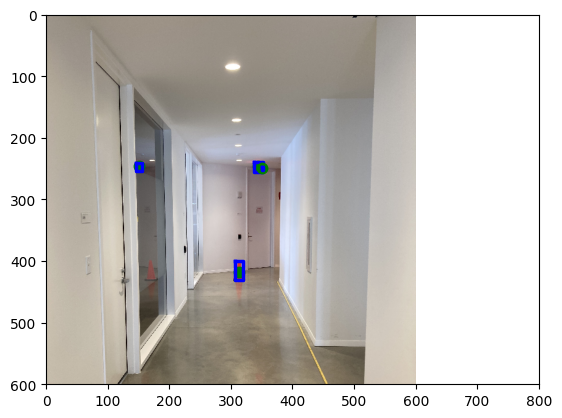


Centroid:  [[245.87943262411346, 343.9645390070922], [246.01923076923077, 150.05769230769232], [249.0, 351.0], [418.1757322175732, 312.77405857740587]]

Bounding Boxes Y length:  [[239, 255], [241, 253], [247, 252], [400, 431]]
16


<Figure size 640x480 with 0 Axes>

In [46]:
def create_bounding_box(unlabeled_img, probability_mask):
    fig, ax = plt.subplots()
    ax.imshow(unlabeled_img, cmap=plt.cm.gray)
    label_img_regions = label(probability_mask) 
    regions = regionprops(label_img_regions)
    centroid_list = []
    bounding_box_list = []

    for props in regions:
        [y0, x0] = props.centroid # Center of the bounding box
        centroid_list.append([y0, x0]) # Append centroids to a list considering not exactly sure 
        
        ax.plot(x0, y0, '.g', markersize=15) # Center point

        minr, minc, maxr, maxc = props.bbox
        bx = (minc, maxc, maxc, minc, minc)
        by = (minr, minr, maxr, maxr, minr)
        ax.plot(bx, by, '-b', linewidth=2.5)
        
        bounding_box_list.append([minr, maxr]) # Append bounding box list

    ax.axis((0, 800, 600, 0))
    plt.show()

    return centroid_list, bounding_box_list


centroids, bounding_boxes = create_bounding_box(unlabeled_img, probability_mask)
print("\nCentroid: ", centroids)
print("\nBounding Boxes Y length: ", bounding_boxes)
#bounding_box_X = maxr - minr
#bounding_box_Y = maxc - minc
bounding_box_Y = bounding_boxes[0][1] - bounding_boxes[0][0] # Get specific bounding box and subtract maxc - minc
print(bounding_box_Y)

# SAVE CREATED PLOT
image_file = open(os.path.join("Data/Final_Output", image_name), "x")
plt.imsave(os.path.join("Data/Final_Output", image_name), )
image_file.close()

Now that we have the bounding box, we can calculate the distance from the camera to the cone. To do calculate this distance we can use the pinhole camera model. Using the distance given in the name of the file we can calculate the focal length. Once we have this we can use this focal length to now create a function that will calculate the distance from the cone to the camera. 

In [ ]:
def get_focal_length(Y, Z, v):
    return (v * Z) / Y

def get_distance(Y, F, v):
    return (Y * F) / v

width_of_cone = 7.5
height_of_cone = 17
# focal_length = get_focal_length(height_of_cone, 8, bounding_box_Y)
# print(focal_length)
focal_length = 22.941176470588236
#focal_length = 56.470588235294116

distance = get_distance(height_of_cone, focal_length, bounding_box_Y)
print("Distance: ", distance)

Distance:  7.647058823529412
